In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import os
import math
import torch

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, accuracy_score
from functools import partial, reduce
from scipy.stats import ttest_ind, normaltest

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Analysis of CLAM C-Kit 11 classification results
* **accuracy**, **confusion-matrix**, **ROC-curves** and **AUC**
* histogram of **model posteriors**
* determine **operating point** on val. set
* determine **confidence** of validation metrics

#### additionally
* correlations in predictions (special features in misclassified samples)
* analyze heatmaps of misclassified samples

In [12]:
exp_list = ['c-kit-mutation',
            'c-kit-mutation-clam_mb',
            'c-kit-mutation-moco-imgnet', 
            'c-kit-mutation-moco-imgnet-clam_mb',
            'c-kit-mutation-moco-imgnet-lrlower',
            'c-kit-mutation-moco-imgnet-lrlower-clam_mb',
            'c-kit-mutation-moco-imgnet-magprior',
            'c-kit-mutation-moco-imgnet-magprior-clam_mb',
            'c-kit-mutation-moco-imgnet-lrlower-finetuned',
            'c-kit-mutation-moco-imgnet-lrlower-finetuned-clam_mb']

In [4]:
def summary(exp_path):
    summary_csv = pd.read_csv('../results/{}_s1/summary.csv'.format(exp_path))
    # mean val metrics
    print(exp_path)
    print('\n')
    print("Mean val accuracy \033[1m {} \033[0m".format(round(summary_csv['val_acc'].mean(),3)))
    print("Mean val AUC {}".format(round(summary_csv['val_auc'].mean(),3)))
    print("Mean test accuracy \033[1m {} \033[0m".format(round(summary_csv['test_acc'].mean(),3)))
    print("Mean test AUC {}".format(round(summary_csv['test_auc'].mean(),3)))
    print('\n')

In [5]:
for exp_path in exp_list:
    summary(exp_path)

c-kit-mutation


Mean val accuracy  0.794 
Mean val AUC 0.862
Mean test accuracy  0.666 
Mean test AUC 0.739


c-kit-mutation-small


Mean val accuracy  0.811 
Mean val AUC 0.857
Mean test accuracy  0.684 
Mean test AUC 0.751


c-kit-mutation-clam_mb


Mean val accuracy  0.797 
Mean val AUC 0.866
Mean test accuracy  0.684 
Mean test AUC 0.758


c-kit-mutation-moco-imgnet


Mean val accuracy  0.78 
Mean val AUC 0.861
Mean test accuracy  0.724 
Mean test AUC 0.771


c-kit-mutation-moco-imgnet-clam_mb


Mean val accuracy  0.789 
Mean val AUC 0.852
Mean test accuracy  0.745 
Mean test AUC 0.772


c-kit-mutation-moco-imgnet-lrlower


Mean val accuracy  0.791 
Mean val AUC 0.879
Mean test accuracy  0.695 
Mean test AUC 0.745


c-kit-mutation-moco-imgnet-lrlower-clam_mb


Mean val accuracy  0.797 
Mean val AUC 0.873
Mean test accuracy  0.721 
Mean test AUC 0.75


c-kit-mutation-moco-imgnet-magprior


Mean val accuracy  0.789 
Mean val AUC 0.865
Mean test accuracy  0.705 
Mean test AUC 0.785



In [6]:
def norm_test(x):
    p = normaltest(x).pvalue
    if p < 0.05:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis: x comes from a normal distribution; can be rejected")
    else:
        print("The null hypothesis: x comes from a normal distribution; can NOT be rejected")
        
def t_test(a, b):
    
    p = ttest_ind(a,b).pvalue
    if p < 0.05:
        print("The null hypothesis: samples have identical average (expected) values; can be rejected. p: ", p)
    else:
        print("The null hypothesis: samples have identical average (expected) values; can NOT be rejected. p: ", p)


In [7]:
# test for significance
a = pd.read_csv('../results/{}_s1/summary.csv'.format('c-kit-mutation'))['test_auc']
b = pd.read_csv('../results/{}_s1/summary.csv'.format('c-kit-mutation-moco-imgnet-lrlower-finetuned'))['test_auc']

norm_test(a)
norm_test(b)
t_test(a,b)

The null hypothesis: x comes from a normal distribution; can NOT be rejected
The null hypothesis: x comes from a normal distribution; can NOT be rejected
The null hypothesis: samples have identical average (expected) values; can be rejected. p:  0.014196623472948403


In [8]:
# test for significance
a = pd.read_csv('../results/{}_s1/summary.csv'.format('c-kit-mutation-clam_mb'))['test_auc']
b = pd.read_csv('../results/{}_s1/summary.csv'.format('c-kit-mutation-moco-imgnet-lrlower-finetuned-clam_mb'))['test_auc']

norm_test(a)
norm_test(b)
t_test(a,b)

The null hypothesis: x comes from a normal distribution; can NOT be rejected
The null hypothesis: x comes from a normal distribution; can NOT be rejected
The null hypothesis: samples have identical average (expected) values; can be rejected. p:  0.028346407875857616


In [9]:
# test for significance
a = pd.read_csv('../results/{}_s1/summary.csv'.format('c-kit-mutation'))['test_auc']
b = pd.read_csv('../results/{}_s1/summary.csv'.format('c-kit-mutation-moco-imgnet-magprior'))['test_auc']

norm_test(a)
norm_test(b)
t_test(a,b)

The null hypothesis: x comes from a normal distribution; can NOT be rejected
The null hypothesis: x comes from a normal distribution; can NOT be rejected
The null hypothesis: samples have identical average (expected) values; can be rejected. p:  0.013357959349297541


### Prediction accuracy of positive and negative samples

In [15]:
def print_confusion_matrix(exp_path):
    # load evaluation results val. set
    folds = {}
    for fold in range(10):
        folds[fold] = pd.read_csv(f'../eval_results/EVAL_{exp_path}/fold_{fold}.csv')

    data_full = pd.concat(folds.values(), axis=0)
    
    y = np.array([])
    y_hat = np.array([])

    for fold in folds:
        y = np.append(y, folds[fold]['Y'])
        y_hat = np.append(y_hat, folds[fold]['Y_hat'])
        
    # confusion matrix
    cm = confusion_matrix(y, y_hat)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(8,6))
    sns.heatmap(cmn, annot=True, fmt='.2f', cmap="YlGnBu")
    plt.ylabel('Ground Truth')
    plt.xlabel('Predicted')
    plt.title(exp_path)
    plt.show(block=False)

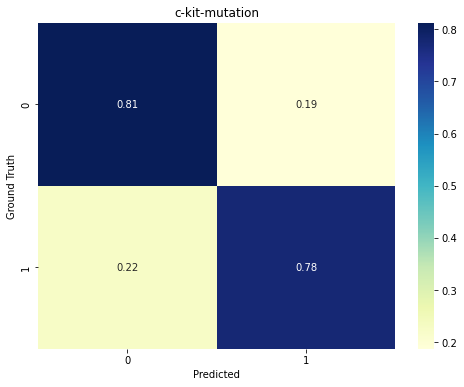

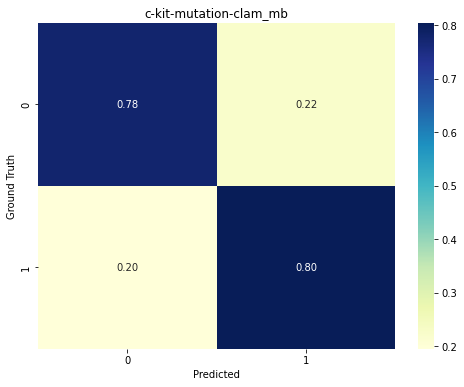

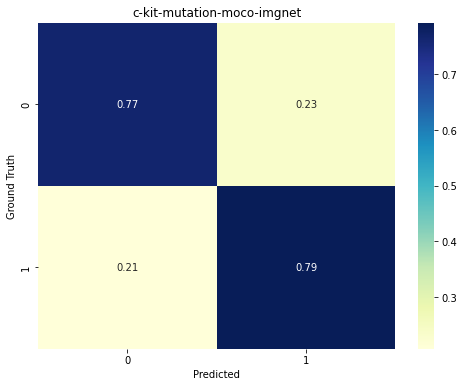

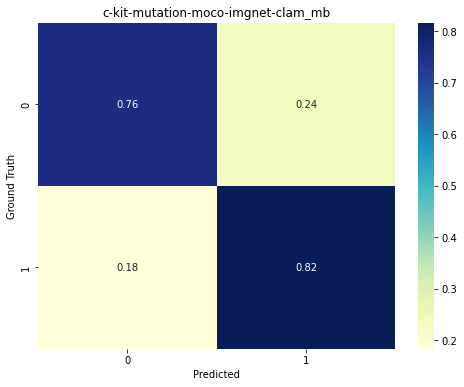

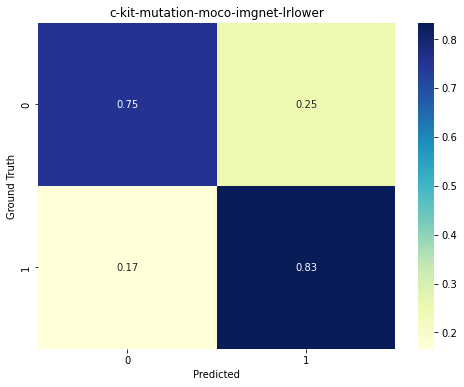

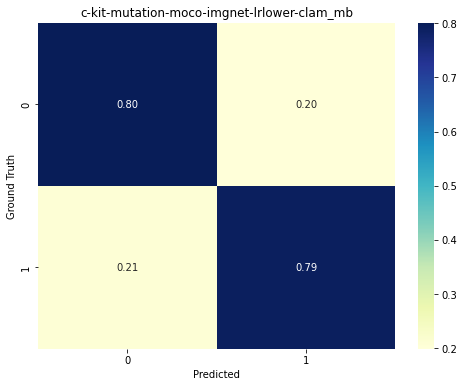

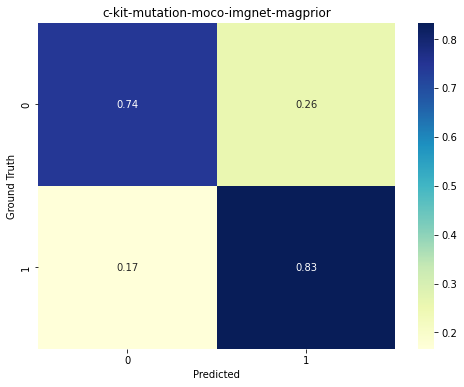

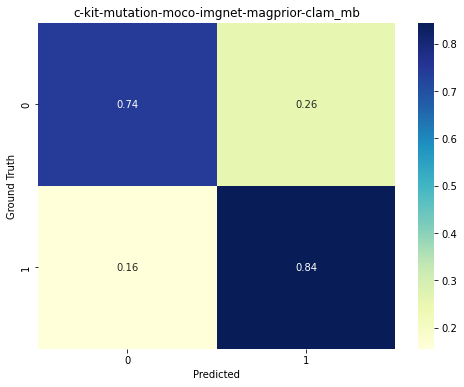

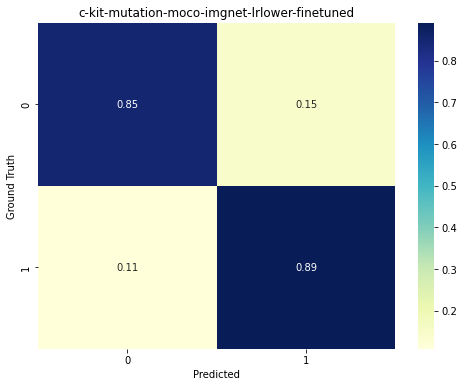

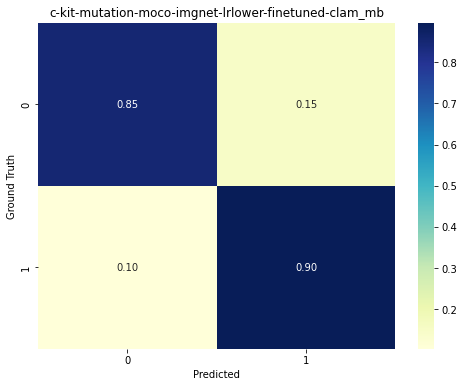

In [16]:
for exp_path in exp_list:
    print_confusion_matrix(exp_path)

In [ ]:
def print_acc_per_class(exp_path):
    # load evaluation results val. set
    folds = {}
    for fold in range(10):
        folds[fold] = pd.read_csv(f'../eval_results/EVAL_{exp_path}/fold_{fold}.csv')

    data_full = pd.concat(folds.values(), axis=0)
    
    # show accuracy per class for each fold
    pos_acc = np.array([])
    neg_acc = np.array([])
    for fold in folds:
        f = folds[fold]
        _, recall, _, _ = precision_recall_fscore_support(f['Y'], f['Y_hat'])
        pos_acc = np.append(pos_acc, recall[1])
        neg_acc = np.append(neg_acc, recall[0])
    acc_per_class = pd.DataFrame(data={'pos': pos_acc, 'neg': neg_acc})
    
    sns.boxplot(data=acc_per_class)
    plt.ylim(0.3, 1)
    plt.ylabel('Accuracy')
    plt.title(f'{exp_path} Accuracy per class (over 10 folds)')
    plt.show()

In [ ]:
for exp_path in exp_list:
    print_acc_per_class(exp_path)

In [ ]:
def print_distribution(exp_path):
    # load evaluation results val. set
    folds = {}
    for fold in range(10):
        folds[fold] = pd.read_csv(f'../eval_results/EVAL_{exp_path}/fold_{fold}.csv')
    
    pos_df = pd.DataFrame([])
    neg_df = pd.DataFrame([])

    for fold in folds:
        f = folds[fold]
        f['fold'] = np.full(f.shape[0], fold)
        pos = f.loc[f['Y'] == 1]
        neg = f.loc[f['Y'] == 0]
        pos_df = pos_df.append(pos)
        neg_df = neg_df.append(neg)
        
    plt.figure(figsize=(15,7))
    plt.hist(neg_df['p_1'], bins=50, label='Negatives')
    plt.hist(pos_df['p_1'], bins=50, label='Positives', alpha=0.7, color='r')
    plt.xlabel('Probability of being Positive Class', fontsize=25)
    plt.ylabel('Number of samples', fontsize=25)
    plt.legend(fontsize=15)
    plt.title(exp_path, fontsize=25)
    plt.tick_params(axis='both', labelsize=25, pad=5)
    plt.show()

In [ ]:
for exp_path in exp_list:
    print_distribution(exp_path)

In [17]:
def print_ROC(exp_path):
    # load evaluation results val. set
    folds = {}
    for fold in range(10):
        folds[fold] = pd.read_csv(f'../eval_results/EVAL_{exp_path}/fold_{fold}.csv')
        
    # ROC curve
    tprs = []
    base_fpr = np.linspace(0, 1, 101)

    plt.figure(figsize=(7, 7))
    plt.axes().set_aspect('equal', 'datalim')

    for fold in folds:
        f = folds[fold]
        fpr, tpr, _ = roc_curve(f['Y'], f['p_1'])

        plt.plot(fpr, tpr, 'b', alpha=0.1)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std


    plt.plot(base_fpr, mean_tprs, 'b')
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title(exp_path)
    plt.show()

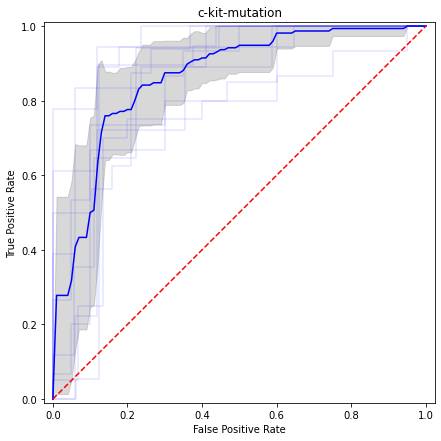

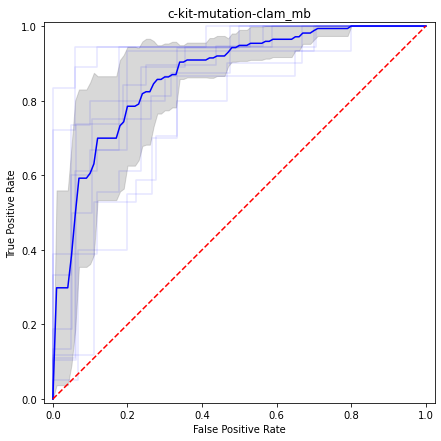

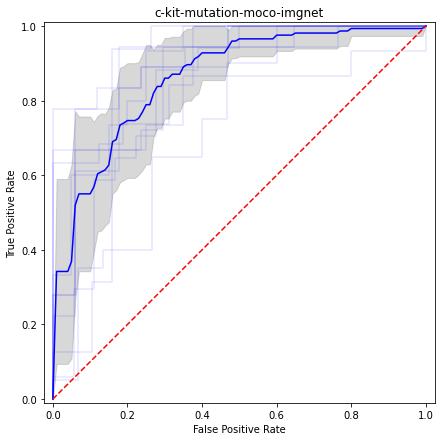

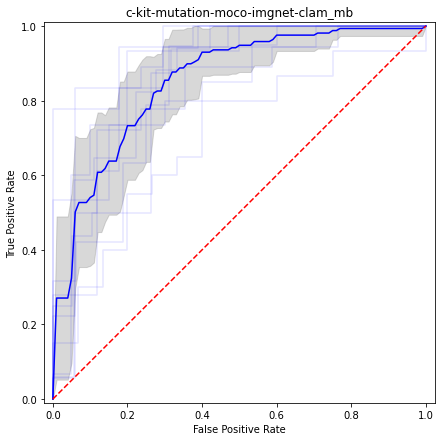

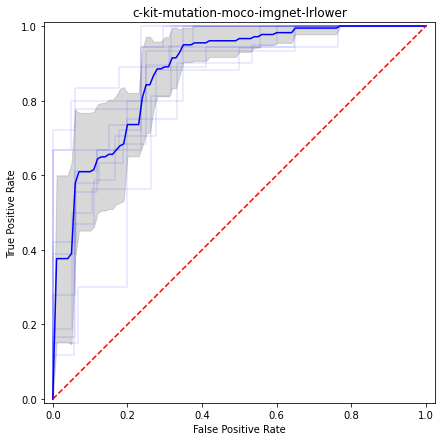

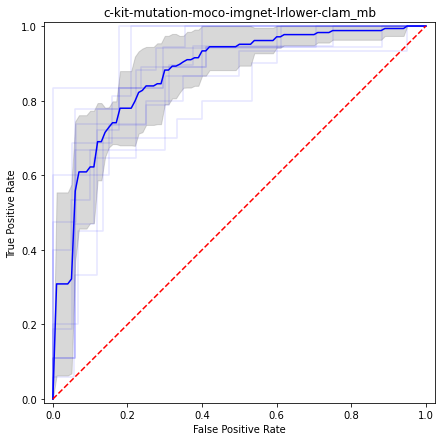

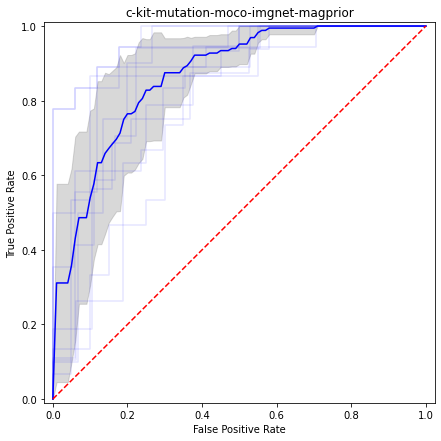

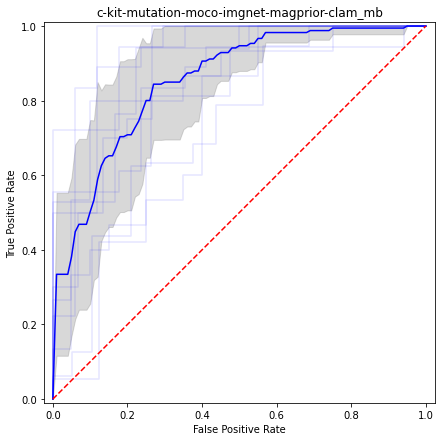

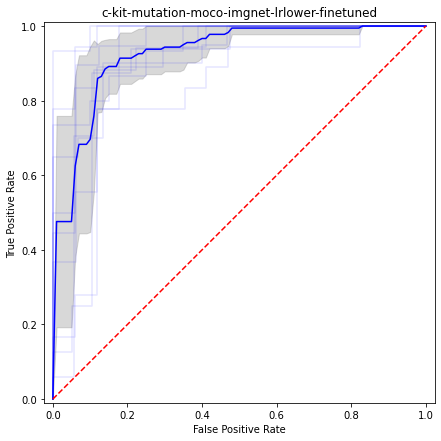

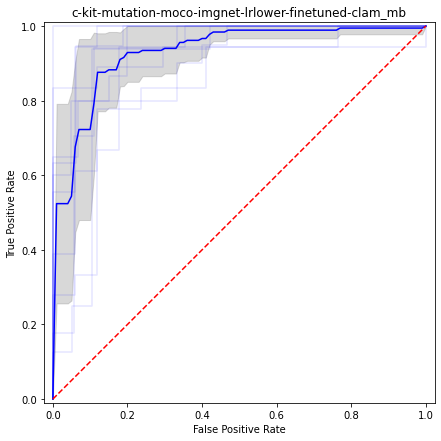

In [18]:
for exp_path in exp_list:
    print_ROC(exp_path)

## Optimal Threshold ROC curve

In [ ]:
# calculate the g-mean for each threshold
def optimal_thresh(name):
    folds = {}
    acc_arr = []
    for fold in range(10):
        folds[fold] = pd.read_csv(f'../eval_results/EVAL_{name}/fold_{fold}.csv')
    for fold in folds:
        f = folds[fold]
        fpr, tpr, thresh = roc_curve(f['Y'], f['p_1'])
        gmeans = np.sqrt(tpr * (1 - fpr))
        idx = np.argmax(gmeans)
        # accuracy for optimal threshold in this fold
        probs = f['p_1'].apply(lambda x: 1 if x > thresh[idx] else 0)
        acc_arr.append(accuracy_score(folds[fold]['Y'] ,probs))

    print('Accuracy with optimal threshold {}: {}'.format(name, round(np.mean(acc_arr),3)))

In [ ]:
for exp_path in exp_list:
    optimal_thresh(exp_path)

In [ ]:
def misclassified_samples(name):
    folds = {}
    misclassified = []
    for fold in range(10):
        folds[fold] = pd.read_csv(f'../eval_results/EVAL_{name}/fold_{fold}.csv')
    for fold in folds:
        f = folds[fold]
        fpr, tpr, thresh = roc_curve(f['Y'], f['p_1'])
        gmeans = np.sqrt(tpr * (1 - fpr))
        idx = np.argmax(gmeans)
        # accuracy for optimal threshold in this fold
        f['y_hat_opt_thresh'] = f['p_1'].apply(lambda x: 1 if x > thresh[idx] else 0)
        samples = f.loc[f['y_hat_opt_thresh'] != f['Y']]
        for s in samples['slide_id'].values:
            misclassified.append(s)
        
    return misclassified


In [ ]:
miscl = []
for exp_path in exp_list:
    miscl += misclassified_samples(exp_path)
    

In [ ]:
from collections import Counter

count = Counter(miscl)
countcount = Counter(list(count.values()))

In [ ]:
countcount

In [ ]:
a = [1, 2, 3, 4, 5]
b = [55, 29, 24, 22, 15]
plt.bar(a,b)

## Correlations with misclassified samples

- **Corellations between misclassified samples and other variables**
- **Corellations between misclassified samples and size of image**

In [19]:
folds = {}
for fold in range(10):
    folds[fold] = pd.read_csv(f'../eval_results/EVAL_c-kit-mutation-moco-imgnet-lrlower/fold_{fold}.csv')

data_full = pd.concat(folds.values(), axis=0)

In [20]:
ckit_metadata = pd.read_csv('../dataset_csv/ckit_data_metadata.csv')
import re

# only keep rows with MP ID
ckit_metadata = ckit_metadata[ckit_metadata['MP ID'].notna()]

# only keep important columns
ckit_metadata = ckit_metadata[['MP ID', 'Breed', 'Age (years)', 'KIT Pattern', 'Ki67', 'AgNOR', 'AgNOR x Ki67', 'Kiupel', 'Patnaik']]
ckit_metadata['MP ID'] = 'CP_' + ckit_metadata['MP ID'].astype(str)

# add MP ID to slides in model prediction data; delete endings (_L1, _L2, _H1, _H2)
data_full['MP ID'] = data_full['slide_id'].transform(lambda x: re.sub('_[^_]*$', '', x) if x.count('_')>1 else x).astype(str)
ckit_metadata['MP ID'] = ckit_metadata['MP ID'].transform(lambda x: x.replace(' ','')).astype(str)

In [21]:
ckit_metadata

,MP ID,Breed,Age (years),KIT Pattern,Ki67,AgNOR,AgNOR x Ki67,Kiupel,Patnaik
0,CP_MP-21-0009973,Mixed,12,2,31.4,2.7,84.78,High,2
1,CP_MP-21-0009594,Mixed,11,2,18.4,1.43,26.37,High,2
2,CP_MP-21-0009589,Boxer,6,2,13.4,2.57,34.39,High,3
3,CP_MP-21-0009587,?,?,2,17.8,3.2,56.96,High,2
4,CP_MP-21-0009586,Vizsla,11,2,36,3.7,133.2,Low,2
...,...,...,...,...,...,...,...,...,...
431,CP_MP-17-0014094,Pug,7,2,17,2,34,Low,2
432,CP_MP-17-0013531,Mixed,?,2,38,2.3,87.4,Low,2
433,CP_MP-21-0000853,Basset Hound,11,2,12,1.4,16.8,Low,1
434,CP_MP-21-0000225,"Poodle, Toy",7,2,1.6,1.47,2.35,Low,1


In [22]:
data_full

,slide_id,Y,Y_hat,p_0,p_1,MP ID
0,CP_MP-19-0004383,1.0,1.0,0.457088,0.542912,CP_MP-19-0004383
1,CP_MP-21-0003988,1.0,0.0,0.648030,0.351970,CP_MP-21-0003988
2,CP_MP-19-0006084,1.0,1.0,0.229946,0.770054,CP_MP-19-0006084
3,CP_MP-20-0008886,1.0,1.0,0.316599,0.683401,CP_MP-20-0008886
4,CP_MP-18-0003823,1.0,1.0,0.268745,0.731255,CP_MP-18-0003823
...,...,...,...,...,...,...
30,CP_MP-18-0007619_H2,0.0,0.0,0.655111,0.344889,CP_MP-18-0007619
31,CP_MP-18-0007034_H3,0.0,1.0,0.301532,0.698468,CP_MP-18-0007034
32,CP_MP-21-0010909_H2,0.0,0.0,0.999271,0.000729,CP_MP-21-0010909
33,CP_MP-21-0004978_H3,0.0,0.0,0.716295,0.283705,CP_MP-21-0004978


In [23]:
# join datasets
data_joined = data_full.join(ckit_metadata.set_index('MP ID'), on='MP ID',how='left')

data_joined['Patnaik'] = pd.to_numeric(data_joined['Patnaik'], errors='coerce', downcast='integer')
data_joined['AgNOR x Ki67'] = pd.to_numeric(data_joined['AgNOR x Ki67'], errors='coerce')
data_joined['Ki67'] = pd.to_numeric(data_joined['Ki67'], errors='coerce')
data_joined['AgNOR'] = pd.to_numeric(data_joined['AgNOR'], errors='coerce')
data_joined['Age (years)'] = pd.to_numeric(data_joined['Age (years)'], errors='coerce')
data_joined['misclassified'] = (data_joined['Y'] != data_joined['Y_hat'])
data_joined['FP'] = (data_joined['Y_hat'] == 1) & (data_joined['Y'] == 0)
data_joined['FN'] = (data_joined['Y_hat'] == 0) & (data_joined['Y'] == 1)
data_joined['Kiupel'] = data_joined['Kiupel'].replace('.', np.NaN)

In [24]:
data_joined

,slide_id,Y,Y_hat,p_0,p_1,MP ID,Breed,Age (years),KIT Pattern,Ki67,AgNOR,AgNOR x Ki67,Kiupel,Patnaik,misclassified,FP,FN
0,CP_MP-19-0004383,1.0,1.0,0.457088,0.542912,CP_MP-19-0004383,Labrador,8.0,2.0,38.0,1.80,68.40,Low,1.0,False,False,False
1,CP_MP-21-0003988,1.0,0.0,0.648030,0.351970,CP_MP-21-0003988,Mixed,12.0,1.0,15.0,2.00,29.60,Low,2.0,True,False,True
2,CP_MP-19-0006084,1.0,1.0,0.229946,0.770054,CP_MP-19-0006084,Golden Retriever,6.0,1.0,10.0,2.10,21.00,Low,2.0,False,False,False
3,CP_MP-20-0008886,1.0,1.0,0.316599,0.683401,CP_MP-20-0008886,Mixed,6.0,2.0,40.0,3.00,120.00,High,2.0,False,False,False
4,CP_MP-18-0003823,1.0,1.0,0.268745,0.731255,CP_MP-18-0003823,Mixed,4.0,2.0,56.0,4.00,224.00,High,2.0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,CP_MP-18-0007619_H2,0.0,0.0,0.655111,0.344889,CP_MP-18-0007619,Labrador,12.0,2.0,55.0,2.70,148.50,High,2.0,False,False,False
31,CP_MP-18-0007034_H3,0.0,1.0,0.301532,0.698468,CP_MP-18-0007034,?,11.0,2.0,46.0,3.20,147.20,High,3.0,True,True,False
32,CP_MP-21-0010909_H2,0.0,0.0,0.999271,0.000729,CP_MP-21-0010909,Golden Retriever,9.0,2.0,65.0,2.20,143.00,High,2.0,False,False,False
33,CP_MP-21-0004978_H3,0.0,0.0,0.716295,0.283705,CP_MP-21-0004978,Labrador,13.0,2.0,75.0,3.50,259.40,High,3.0,False,False,False


In [25]:
data_joined.to_csv('new.csv')

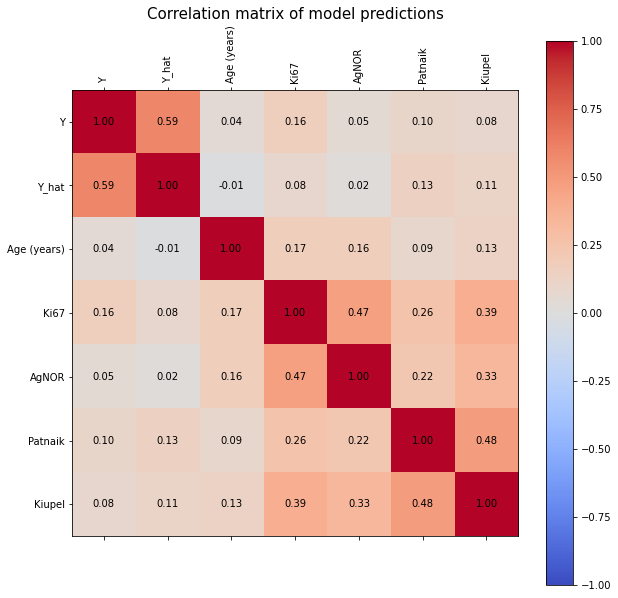

In [26]:
# show correlations between variables

partial_data = data_joined[['Y','Y_hat','Age (years)','Ki67','AgNOR','Patnaik', 'Kiupel']]
partial_data['Kiupel'] = partial_data['Kiupel'].replace('Low', 0)
partial_data['Kiupel'] = partial_data['Kiupel'].replace('High', 1)
corr = partial_data.corr()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(corr.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)
for (x, y), value in np.ndenumerate(corr):
    plt.text(x, y, f"{value:.2f}", va="center", ha="center")
plt.title('Correlation matrix of model predictions', fontsize=15)
plt.show()

In [27]:
data_joined.describe()

,Y,Y_hat,p_0,p_1,Age (years),KIT Pattern,Ki67,AgNOR,AgNOR x Ki67,Patnaik
count,350.000000,350.000000,350.000000,350.000000,286.000000,326.000000,323.000000,322.000000,323.000000,326.000000
mean,0.497143,0.540000,0.483055,0.516945,8.246503,1.871166,33.147678,2.398944,88.546502,2.211656
std,0.500708,0.499111,0.333359,0.333359,2.919307,0.402259,26.795617,0.737621,84.186534,0.471970
min,0.000000,0.000000,0.001412,0.000225,0.500000,1.000000,1.000000,1.200000,1.300000,1.000000
25%,0.000000,0.000000,0.161527,0.193055,6.000000,2.000000,12.000000,1.800000,20.955000,2.000000
50%,0.000000,1.000000,0.447025,0.552975,8.000000,2.000000,28.000000,2.300000,70.200000,2.000000
75%,1.000000,1.000000,0.806945,0.838473,10.000000,2.000000,46.000000,2.900000,131.550000,2.000000
max,1.000000,1.000000,0.999775,0.998588,16.000000,3.000000,196.000000,7.500000,627.200000,3.000000


<AxesSubplot: xlabel='Kiupel', ylabel='proportion'>

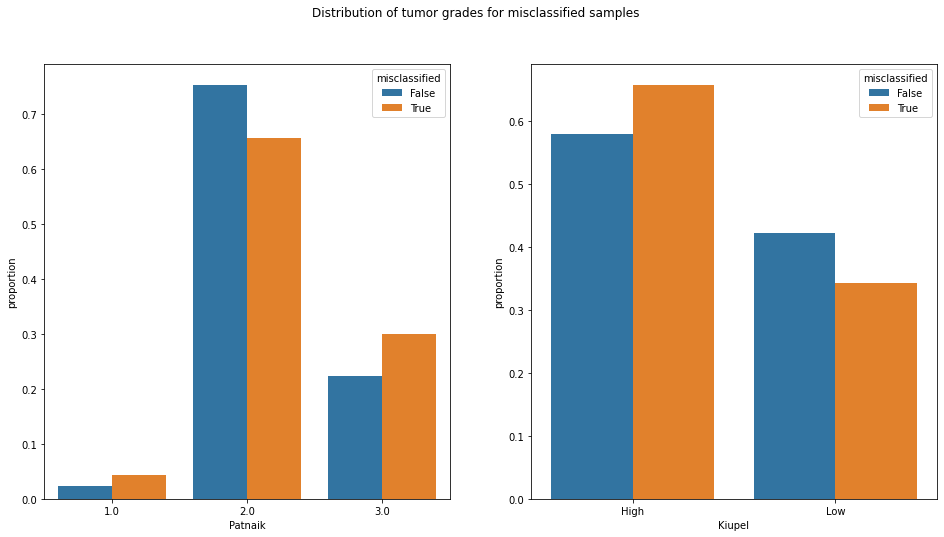

In [28]:
# distribution of tumor grades for accurately classified and misclassified samples
y, hue = "proportion", "misclassified"

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of tumor grades for misclassified samples')

(data_joined['Patnaik']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Patnaik', y=y, hue=hue, ax=ax[0]))
(data_joined['Kiupel']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Kiupel', y=y, hue=hue, ax=ax[1]))

<AxesSubplot: xlabel='Kiupel', ylabel='proportion'>

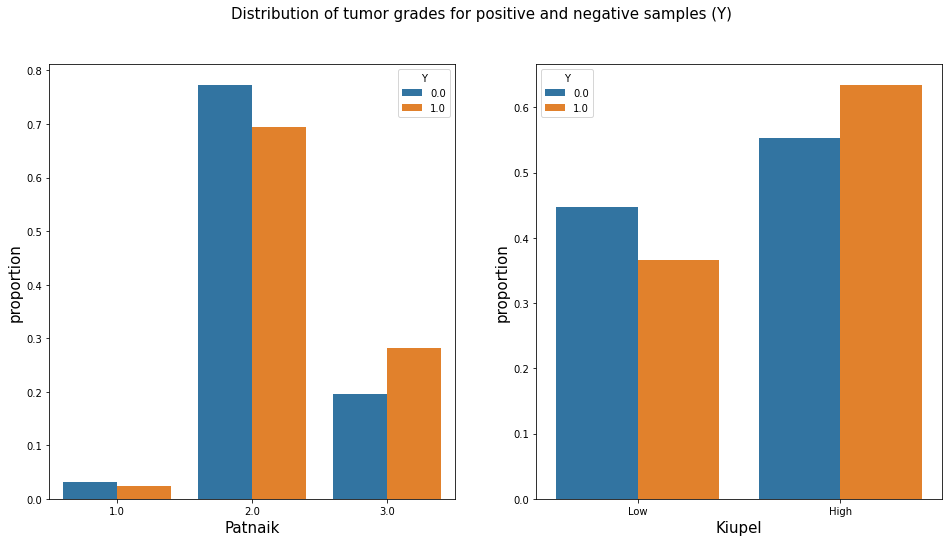

In [29]:
# distribution of tumor grades for positive and negative samples (should be same distribution)
y, hue = "proportion", "Y"

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of tumor grades for positive and negative samples (Y)', fontsize=15)
ax[0].set_xlabel('Patnaik',fontsize=15)
ax[0].set_ylabel('proportion',fontsize=15)
ax[1].set_xlabel('Kiupel',fontsize=15)
ax[1].set_ylabel('proportion',fontsize=15)
(data_joined['Patnaik']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Patnaik', y=y, hue=hue, ax=ax[0]))
(data_joined['Kiupel']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Kiupel', y=y, hue=hue, ax=ax[1], order=['Low', 'High']))

<AxesSubplot: xlabel='Kiupel', ylabel='proportion'>

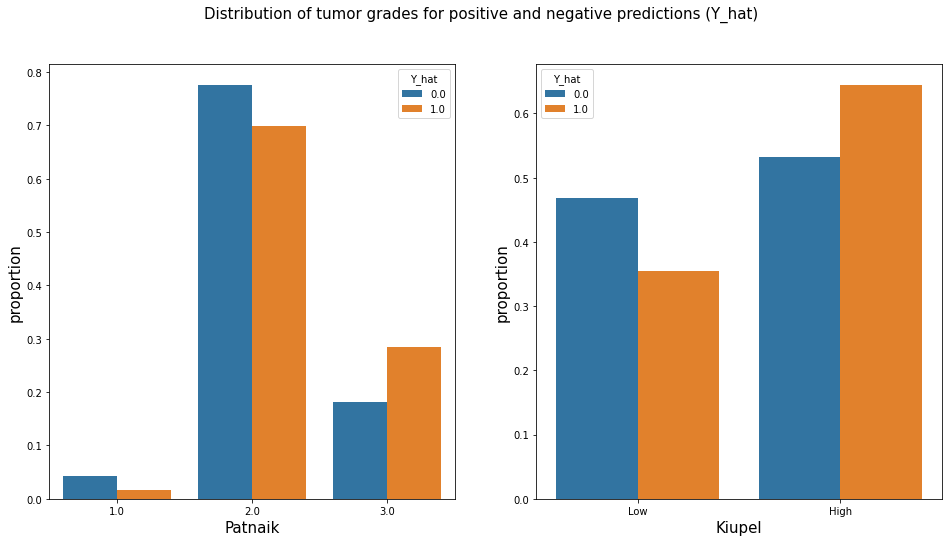

In [30]:
# distribution of tumor grades for positive and negative samples (should be same distribution)
y, hue = "proportion", "Y_hat"

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of tumor grades for positive and negative predictions (Y_hat)', fontsize=15)
ax[0].set_xlabel('Patnaik',fontsize=15)
ax[0].set_ylabel('proportion',fontsize=15)
ax[1].set_xlabel('Kiupel',fontsize=15)
ax[1].set_ylabel('proportion',fontsize=15)
(data_joined['Patnaik']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Patnaik', y=y, hue=hue, ax=ax[0]))
(data_joined['Kiupel']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Kiupel', y=y, hue=hue, ax=ax[1],order=['Low', 'High']))

In [31]:
# distribution of tumor grades for FN and TP

def func(x):
    if (x['Y']==1 ) & (x['Y_hat']==0):
        return 'False Neg'
    elif (x['Y']==0 ) & (x['Y_hat']==1):
        return 'False Pos'
    else: 
        return 'True'

data_joined['type'] = data_joined.apply(func, axis=1)


<AxesSubplot: xlabel='Kiupel', ylabel='proportion'>

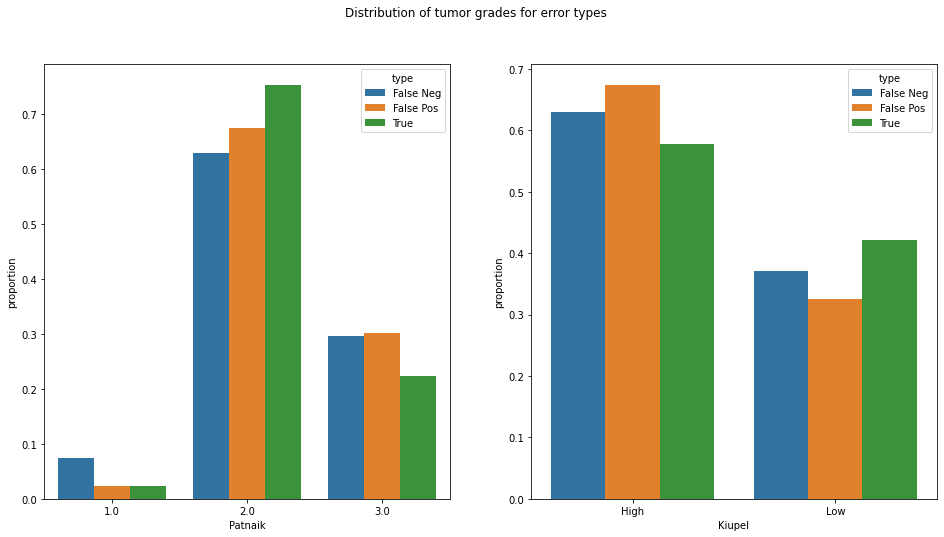

In [32]:
# show distribution of Patnaik Tumor grade for both FN and TP
y, hue = "proportion", "type"

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of tumor grades for error types')

(data_joined['Patnaik']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Patnaik', y=y, hue=hue, ax=ax[0]))
(data_joined['Kiupel']
 .groupby(data_joined[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x='Kiupel', y=y, hue=hue, ax=ax[1]))

<AxesSubplot: xlabel='Patnaik', ylabel='AgNOR x Ki67'>

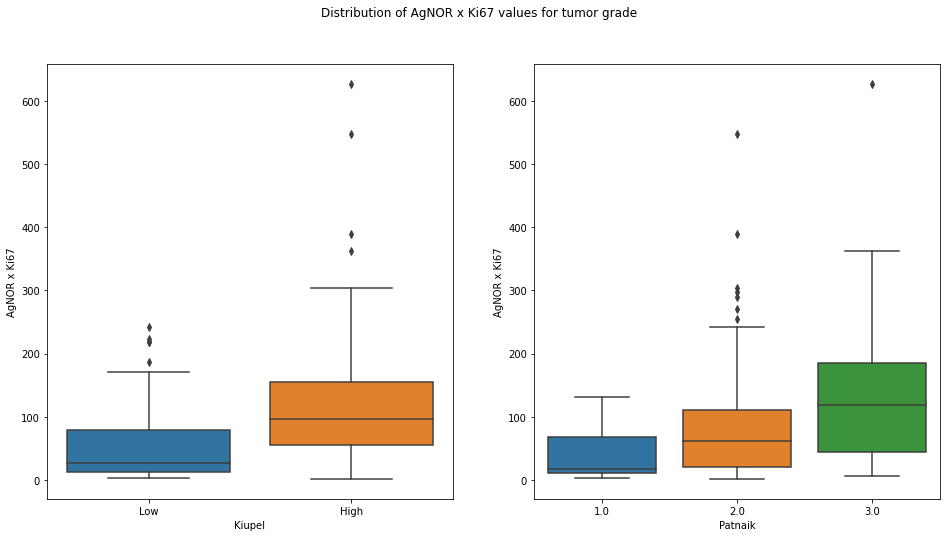

In [33]:
# show agNor and KI67 values for tumor grade

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of AgNOR x Ki67 values for tumor grade')

sns.boxplot(data=data_joined, x='Kiupel', y='AgNOR x Ki67', ax=ax[0])
sns.boxplot(data=data_joined, x='Patnaik', y='AgNOR x Ki67', ax=ax[1])

<AxesSubplot: xlabel='Y_hat', ylabel='AgNOR x Ki67'>

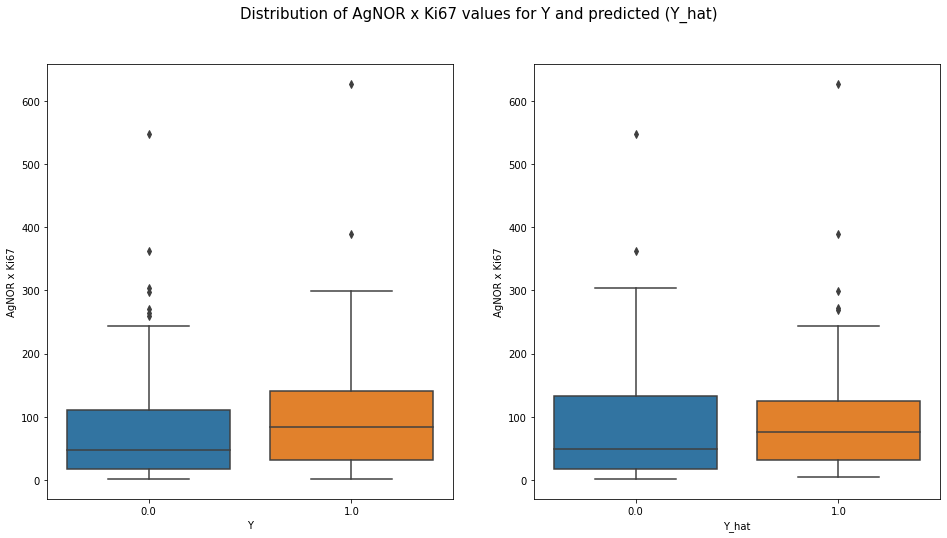

In [37]:
# AgNOR and Ki67 values distribution for Y and Y_hate (prediction)

fig, ax = plt.subplots(1, 2, figsize=(16,8))
fig.suptitle('Distribution of AgNOR x Ki67 values for Y and predicted (Y_hat)', fontsize=15)

sns.boxplot(data=data_joined, x='Y', y='AgNOR x Ki67', ax=ax[0])
sns.boxplot(data=data_joined, x='Y_hat', y='AgNOR x Ki67', ax=ax[1])

In [35]:
# Correlations between model prediction and number of patches in WSI

WSI_DIR = '../../../features/pt_files/'

def get_patch_num(wsi):
    tensor = torch.load(WSI_DIR + wsi['slide_id'] + '.pt')
    num = tensor.shape[0]
    return num

data_joined['num_patches'] = data_joined.apply(get_patch_num, axis=1)

<AxesSubplot: xlabel='misclassified', ylabel='num_patches'>

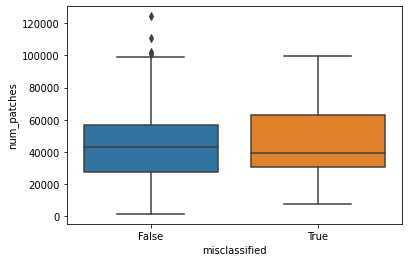

In [36]:
sns.boxplot(data=data_joined, x='misclassified', y='num_patches')